In [2]:
# load dependencies'
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' surpresses warnings at spatial distribution
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import numpy as np
import datetime
import plotly.express as px
import plotly.graph_objects as go

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# pandas show all columns of table instead of restricted
pd.set_option('display.max_columns', None)

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))


In [3]:
bbox = BboxSelector([
    7.554130554199218, # min_x
    51.95590322041212, # min_y
    7.590351104736328, # max_x
    51.97874790276371  # max_y
])

# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=20) 
#df_tracks


In [4]:
# For the moment we only want numerical variables
# Therefore we select only float64
track_df = track_df.select_dtypes(['float64'])
track_df.columns.tolist()

['Engine Load.value',
 'Calculated MAF.value',
 'Speed.value',
 'CO2.value',
 'Intake Pressure.value',
 'Rpm.value',
 'Intake Temperature.value',
 'Consumption (GPS-based).value',
 'GPS Altitude.value',
 'Throttle Position.value',
 'GPS Bearing.value',
 'Consumption.value',
 'GPS Accuracy.value',
 'CO2 Emission (GPS-based).value',
 'GPS Speed.value',
 'track.length',
 'GPS HDOP.value',
 'GPS PDOP.value',
 'GPS VDOP.value']

In [29]:
# We can have a look for the skewness of a distribution by applying the Fisher-Peason standardized moment coefficient on each column
# The higher the value, the more the data is skewed
# Negative values indicate negative left skewness
# Generally a value < 1 is okay
numericFeaturesIndex = track_df.dtypes[track_df.dtypes=='float64'].index
skewedFeatures=track_df[numericFeaturesIndex].skew().sort_values(ascending=False)
skewness=pd.DataFrame({'Skew':skewedFeatures})
skewness

,Skew
CO2.value,19.207353
Consumption.value,19.207353
Calculated MAF.value,19.207353
GPS HDOP.value,15.994399
GPS PDOP.value,15.985921
GPS VDOP.value,15.962941
GPS Accuracy.value,11.005252
Intake Pressure.value,10.057712
Engine Load.value,8.152091
Throttle Position.value,3.877674


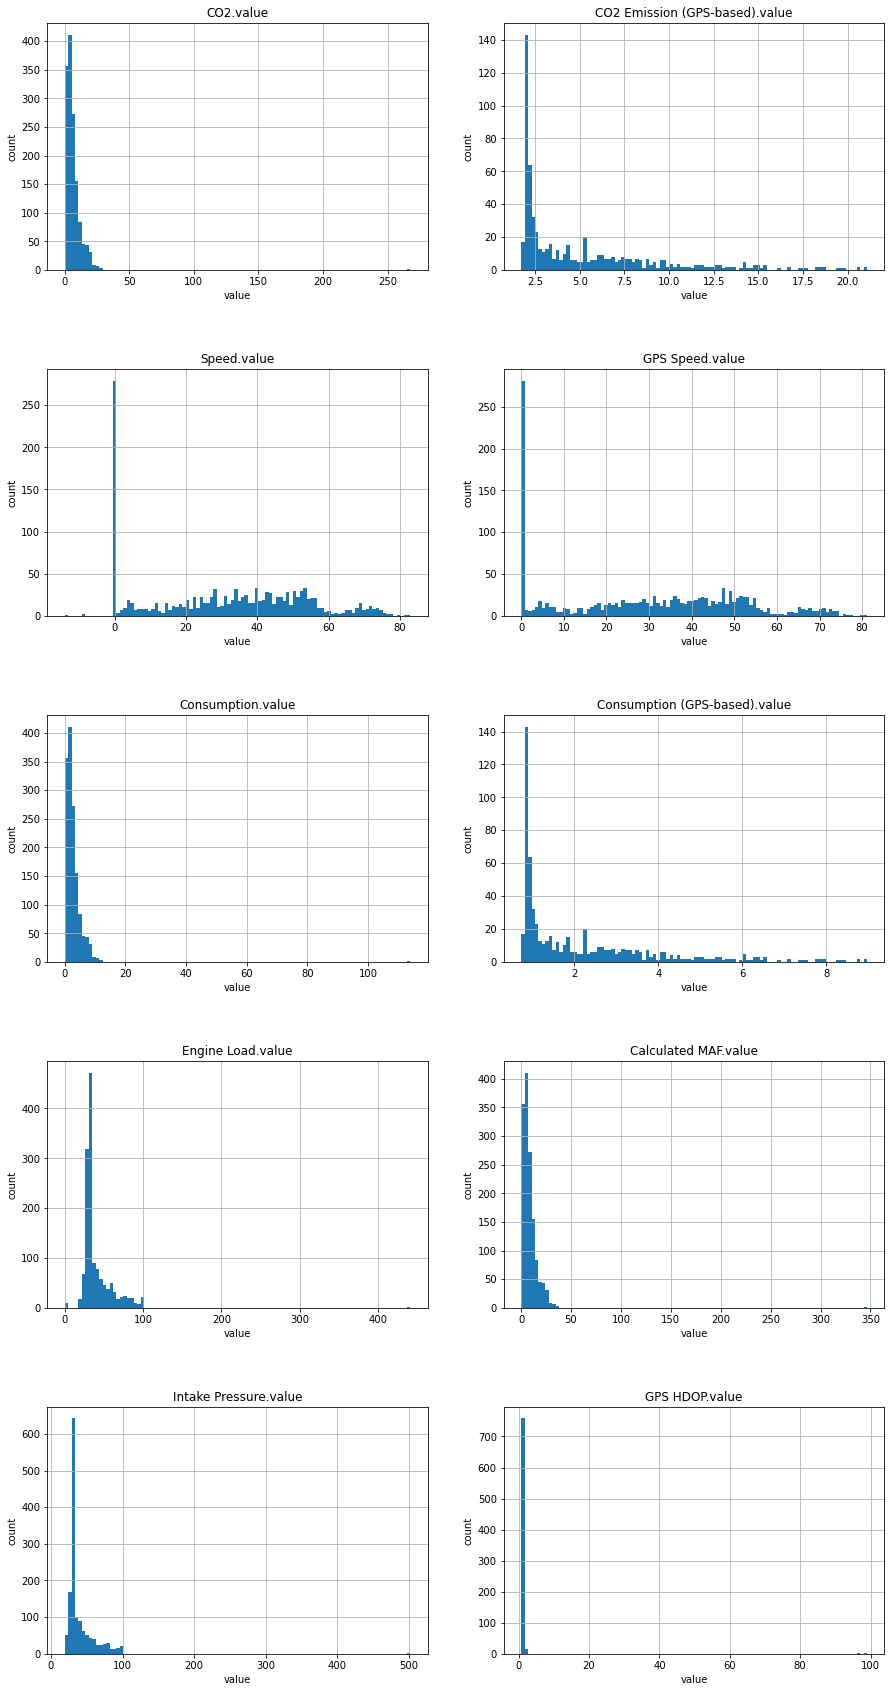

In [9]:
# Plot histograms to see the shape of the distribution of the data
fig, axs = plt.subplots(5, 2,squeeze=False, figsize=(15,30))
plt.subplots_adjust(hspace=0.4)

axs[0, 0].hist(track_df["CO2.value"], bins=100)
axs[0, 0].set_title("CO2.value")

axs[0, 1].hist(track_df['CO2 Emission (GPS-based).value'], bins=100)
axs[0, 1].set_title('CO2 Emission (GPS-based).value')

axs[1, 0].hist(track_df['Speed.value'], bins=100)
axs[1, 0].set_title('Speed.value')

axs[1, 1].hist(track_df['GPS Speed.value'],bins=100)
axs[1, 1].set_title('GPS Speed.value')

axs[2, 0].hist(track_df['Consumption.value'], bins=100)
axs[2, 0].set_title('Consumption.value')

axs[2, 1].hist(track_df['Consumption (GPS-based).value'], bins=100)
axs[2, 1].set_title('Consumption (GPS-based).value')

axs[3, 0].hist(track_df['Engine Load.value'], bins=100)
axs[3, 0].set_title('Engine Load.value')

axs[3, 1].hist(track_df['Calculated MAF.value'], bins=100)
axs[3, 1].set_title('Calculated MAF.value')

axs[4, 0].hist(track_df['Intake Pressure.value'], bins=100)
axs[4, 0].set_title('Intake Pressure.value')

axs[4, 1].hist(track_df['GPS HDOP.value'], bins=100)
axs[4, 1].set_title('GPS HDOP.value')

for ax in axs.flat:
    ax.grid()
    ax.set(xlabel='value', ylabel='count')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

We can see, that the data is often right skewed (or: 'positve skewed'). If we use parametric approaches to analyse the data we would consider to shift data to a normal distribution.

In [77]:
# we can normalize our data. This will just standardize the values to be between 0 and 1 
# this will not change the shape of the distribution
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

In [82]:
# After we normalized the data, we can see much better, that the ditribution is skewed
# the values should be spread over 0-1.0, with the mean in the optimal case at 0.5
# however, we see here, that the mean is at 0.04 and the median at 0.02, so war left of 0.5
intakePressureNormalized = normalize(track_df['Intake Pressure.value']+1)
intakePressureNormalized.describe()

count    1420.000000
mean        0.043904
std         0.050661
min         0.000000
25%         0.022766
50%         0.024836
75%         0.053831
max         1.000000
Name: Intake Pressure.value, dtype: float64

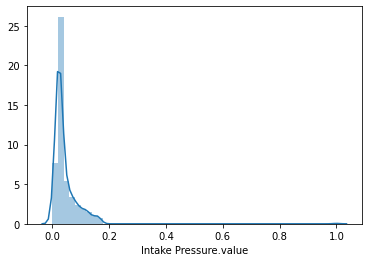

In [83]:
# this can also be seen when we look at the histogram
sns.distplot(intakePressureNormalized)

 We can transform the data to addess this skewness.

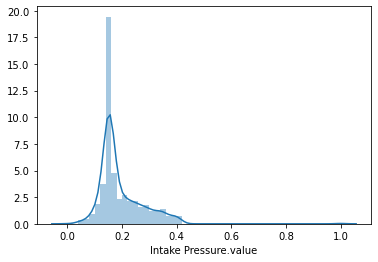

In [84]:
# Square root transformation
squareRoot=intakePressureNormalized**(.5)
sns.distplot(squareRoot)

In [85]:
squareRoot.skew()

2.2707641312516524

In [100]:
# Log transformation
log = np.log(track_df['Intake Pressure.value'])
log=normalize(log)
log.describe()

count    1420.000000
mean        0.202963
std         0.113169
min         0.000000
25%         0.139489
50%         0.149503
75%         0.263381
max         1.000000
Name: Intake Pressure.value, dtype: float64

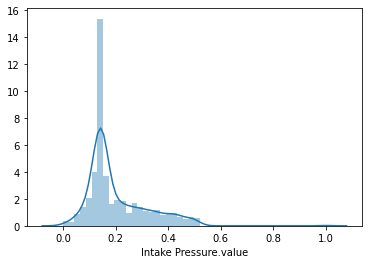

In [101]:
sns.distplot(log)

In [91]:
log.skew()

1.4787174195958326

In [93]:
# Reciprocal Transformation
reciprocal=1/track_df['Intake Pressure.value']
reciprocal=normalize(reciprocal)
reciprocal.describe()

count    1420.000000
mean        0.527387
std         0.169109
min         0.000000
25%         0.399407
50%         0.597681
75%         0.618915
max         1.000000
Name: Intake Pressure.value, dtype: float64

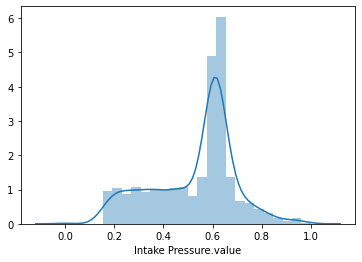

In [94]:
sns.distplot(reciprocal)

In [95]:
reciprocal.skew()

-0.516215353580466

In [96]:
# This is still not perfect, but it also doesn't look too bad
# Mean and median are between 0.5 and 0.6, and not too far from each other, which is good
# However, the 0.25-quantil is at ~ 0.4 and the 0.75-quantil is at ~ 0.61 
reciprocal.describe()

count    1420.000000
mean        0.527387
std         0.169109
min         0.000000
25%         0.399407
50%         0.597681
75%         0.618915
max         1.000000
Name: Intake Pressure.value, dtype: float64

Now we can inspect linear relationships, after we transformed our data
For this, we chose our transformed varaible and plot a regression plot with the variable 'Speed.value' as this is relatively normally distributed (see)

In [112]:
normSpeed = normalize(track_df['Speed.value'])
normSpeed.describe()

count    1420.000000
mean        0.459687
std         0.230500
min         0.000000
25%         0.221539
50%         0.480308
75%         0.648292
max         1.000000
Name: Speed.value, dtype: float64

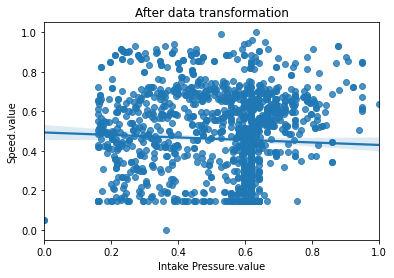

In [120]:
def plot_linear_regression(variableName1, variableName2, title):
    sns.regplot(x=variableName1, y=variableName2).set_title(title)
    
plot_linear_regression(reciprocal, normSpeed, 'After data transformation')

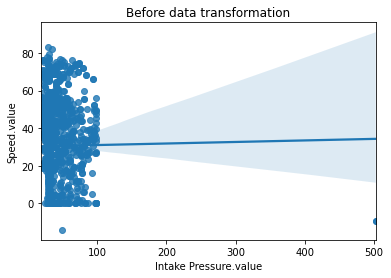

In [121]:
# just for comparison without transformation
plot_linear_regression(track_df['Intake Pressure.value'], track_df['Speed.value'], 'Before data transformation')